## Multivariable Regression

### Prepared by Robin Fladebo     December 2018

### Introduction

Prepare FBI Uniform Crime Reporting data, for the State of New York for 2013, for use in a model with multivariable regression (including data cleaning if necessary) according to this specification:

Propertycrime=α+Population+Population^2+Murder+Robbery

The 'population' variable is already set for you, but you will need to create the last three features. Robbery and Murder are currently continuous variables. For this model, please use these variables to create categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0. Don't forget basic data cleaning procedures. Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.

#### Notes on data content

Property crime includes burglary, larceny-theft and vehicle theft.
Data can be retrieved here: https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

Violent crime includes murder, non-negligent homicide, rape, robbery and aggravated assault.

### Data preparation

In [309]:
import warnings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)
%matplotlib inline
import seaborn as sns

In [310]:
from sklearn import linear_model
import statsmodels.formula.api as smf

In [311]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [312]:
df = pd.read_excel('../Datafiles/fbi_nyc_2013.xlsx',sheet_name='fbi_nyc_2013')

In [313]:
df.shape

(351, 13)

In [314]:
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson'],
      dtype='object')

In [315]:
df.dtypes

City                                       object
Population                                float64
Violent\ncrime                            float64
Murder and\nnonnegligent\nmanslaughter    float64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2               float64
Robbery                                   float64
Aggravated\nassault                       float64
Property\ncrime                           float64
Burglary                                  float64
Larceny-\ntheft                           float64
Motor\nvehicle\ntheft                     float64
Arson                                     float64
dtype: object

In [316]:
df.rename(columns=lambda x: x.replace('\n', '_'), inplace=True)

In [317]:
df.rename(columns=lambda x: x.lower(), inplace=True)

In [318]:
df.rename(columns={'rape_(revised_definition)1':'rape_def_1','rape_(legacy_definition)2':'rape_legacy_def'}, inplace=True)

In [319]:
df.rename(columns={'murder and_nonnegligent_manslaughter':'murder'}, inplace=True)

In [320]:
df.rename(columns={'rape_(revised_definition)1':'rape_def_1','rape_(legacy_definition)2':'rape_legacy_def', 'larceny-_theft':'larceny_theft'}, inplace=True)

Deal with missing data and extraneous rows

In [321]:
# Drop any column that is filled with NA values
df.dropna(how='all', axis=1, inplace=True)

In [322]:
# Keep rows with at least 2 non-NA values (i.e., drop Notes rows)
df.dropna(how='any', thresh=2, inplace=True)

In [323]:
df.drop(df[df['property_crime'] == 0].index, inplace=True)

Create new features

In [324]:
df['pop_sq'] = df['population']**2

In [325]:
df['pop_log'] = np.log(df['population'])

In [326]:
df['pty_crime_sqrt'] = np.sqrt(df['property_crime'])

In [327]:
df['pty_crime_log'] = np.log(df['property_crime'])

In [328]:
def set_ind(var,new_val):
    df[new_val]=np.where(df[var]>0, 1, 0)
    return df
df = set_ind('murder', 'murder_ind')
df = set_ind('robbery', 'robbery_ind')

In [329]:
#compute per capita measures for each variable in use
df['pty_crime_pc']=df['property_crime']/df['population']
df['murder_pc']=df['murder']/df['population']
df['robbery_pc']=df['robbery']/df['population']
df['violent_pc']=df['violent_crime']/df['population']

In [330]:
def set_ind(var,new_val):
    df[new_val]=np.where(df[var]>=0, 1, 0)
    return df
df = set_ind('murder_pc', 'murder_pc_ind')
df = set_ind('robbery_pc', 'robbery_pc_ind')
df = set_ind('violent_pc', 'violent_pc_ind')

In [331]:
df['outlier_flag'] = np.where(df['population']>200000, 1, 0)

In [332]:
df['low_outlier'] = np.where(df['population']<5000, 1, 0 )

In [333]:
df.groupby(df['outlier_flag']).count()

,city,population,violent_crime,murder,rape_legacy_def,robbery,aggravated_assault,property_crime,burglary,larceny_theft,...,robbery_ind,pty_crime_pc,murder_pc,robbery_pc,violent_pc,murder_pc_ind,robbery_pc_ind,violent_pc_ind,outlier_flag,low_outlier
outlier_flag,,,,,,,,,,,,,,,,,,,,,
0,339,339,339,339,339,339,339,339,339,339,...,339,339,339,339,339,339,339,339,339,339
1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [334]:
df.groupby(df['low_outlier']).count()

,city,population,violent_crime,murder,rape_legacy_def,robbery,aggravated_assault,property_crime,burglary,larceny_theft,...,murder_ind,robbery_ind,pty_crime_pc,murder_pc,robbery_pc,violent_pc,murder_pc_ind,robbery_pc_ind,violent_pc_ind,outlier_flag
low_outlier,,,,,,,,,,,,,,,,,,,,,
0,215,215,215,215,215,215,215,215,215,215,...,215,215,215,215,215,215,215,215,215,215
1,127,127,127,127,127,127,127,127,127,127,...,127,127,127,127,127,127,127,127,127,127


### Data analysis

In [335]:
df.describe()

,population,violent_crime,murder,rape_legacy_def,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,...,robbery_ind,pty_crime_pc,murder_pc,robbery_pc,violent_pc,murder_pc_ind,robbery_pc_ind,violent_pc_ind,outlier_flag,low_outlier
count,3.420000e+02,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,...,342.000000,342.000000,342.000000,342.000000,342.000000,342.0,342.0,342.0,342.000000,342.000000
mean,4.071809e+04,205.131579,1.593567,5.967836,74.181287,123.388889,806.511696,121.783626,648.192982,36.535088,...,0.611111,0.019823,0.000011,0.000383,0.001561,1.0,1.0,1.0,0.008772,0.371345
std,4.539497e+05,2839.800152,18.462811,60.949685,1040.018245,1720.999750,7726.090635,932.913244,6401.073911,406.929173,...,0.488212,0.014494,0.000035,0.000721,0.002082,0.0,0.0,0.0,0.093384,0.483872
min,5.260000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000168,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000
25%,3.077500e+03,2.000000,0.000000,0.000000,0.000000,1.000000,42.000000,6.000000,32.000000,0.000000,...,0.000000,0.009439,0.000000,0.000000,0.000383,1.0,1.0,1.0,0.000000,0.000000
50%,7.465500e+03,6.000000,0.000000,0.000000,1.000000,5.000000,114.000000,18.000000,95.500000,2.000000,...,1.000000,0.016390,0.000000,0.000154,0.000867,1.0,1.0,1.0,0.000000,0.000000
75%,1.927950e+04,22.000000,0.000000,2.000000,5.000000,14.000000,342.500000,52.000000,288.750000,7.000000,...,1.000000,0.026201,0.000000,0.000451,0.001890,1.0,1.0,1.0,0.000000,1.000000
max,8.396126e+06,52384.000000,335.000000,1112.000000,19170.000000,31767.000000,141971.000000,16606.000000,117931.000000,7434.000000,...,1.000000,0.123624,0.000227,0.005250,0.015225,1.0,1.0,1.0,1.000000,1.000000


Create new features based on quartile distribution of population

In [336]:
df['qrtl_1']=np.where(df['population']<3004, 1, 0)
df['qrtl_2']=np.where((df['population']>3003) & (df['population']<7234), 1, 0)
df['qrtl_3']=np.where((df['population']>7233) & (df['population']<184270), 1, 0)
df['qrtl_4']=np.where(df['population']>184271, 1, 0)

In [337]:
df.corr()

,population,violent_crime,murder,rape_legacy_def,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,...,violent_pc,murder_pc_ind,robbery_pc_ind,violent_pc_ind,outlier_flag,low_outlier,qrtl_1,qrtl_2,qrtl_3,qrtl_4
population,1.000000,0.998855,0.986756,0.990839,0.998471,0.999136,0.996267,0.970588,0.997947,0.992420,...,0.150263,NaN,NaN,NaN,0.604845,-0.064607,-0.047670,-0.046178,-0.034089,0.534090
violent_crime,0.998855,1.000000,0.992099,0.994990,0.999923,0.999942,0.998068,0.978176,0.998769,0.996273,...,0.173540,NaN,NaN,NaN,0.631700,-0.054738,-0.039938,-0.040895,-0.049942,0.555846
murder,0.986756,0.992099,1.000000,0.997747,0.993105,0.990843,0.995405,0.993749,0.993176,0.997992,...,0.229588,NaN,NaN,NaN,0.713048,-0.066434,-0.048154,-0.049397,-0.050407,0.624931
rape_legacy_def,0.990839,0.994990,0.997747,1.000000,0.995444,0.994145,0.997843,0.992450,0.996259,0.998764,...,0.228631,NaN,NaN,NaN,0.685825,-0.071983,-0.054061,-0.051650,-0.038775,0.603325
robbery,0.998471,0.999923,0.993105,0.995444,1.000000,0.999742,0.998246,0.979551,0.998742,0.996930,...,0.174877,NaN,NaN,NaN,0.639754,-0.054591,-0.039674,-0.041057,-0.051593,0.563133
aggravated_assault,0.999136,0.999942,0.990843,0.994145,0.999742,1.000000,0.997631,0.976313,0.998568,0.995405,...,0.170117,NaN,NaN,NaN,0.623812,-0.054071,-0.039495,-0.040310,-0.049317,0.548815
property_crime,0.996267,0.998068,0.995405,0.997843,0.998246,0.997631,1.000000,0.987140,0.999666,0.998303,...,0.199832,NaN,NaN,NaN,0.658842,-0.075171,-0.055843,-0.053664,-0.029829,0.576922
burglary,0.970588,0.978176,0.993749,0.992450,0.979551,0.976313,0.987140,1.000000,0.982704,0.991477,...,0.286950,NaN,NaN,NaN,0.750170,-0.093519,-0.069632,-0.065810,-0.025558,0.660792
larceny_theft,0.997947,0.998769,0.993176,0.996259,0.998742,0.998568,0.999666,0.982704,1.000000,0.996878,...,0.185863,NaN,NaN,NaN,0.642273,-0.072844,-0.054142,-0.052010,-0.029370,0.561361
motor_vehicle_theft,0.992420,0.996273,0.997992,0.998764,0.996930,0.995405,0.998303,0.991477,0.996878,1.000000,...,0.212555,NaN,NaN,NaN,0.686084,-0.066975,-0.048956,-0.049875,-0.045752,0.608395


#### Clearly there are outlier values in the predictor population. A histogram of population consists of two visible bars and an outlier representing three large cities.

Text(0.5,1,'Frequency distribution of population of reporting cities in FBI UCR data - New York State')

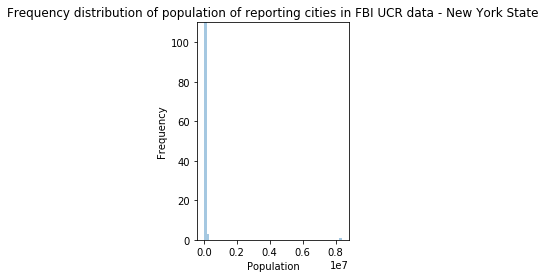

In [338]:
#Review the population distribution
plt.subplot(1, 2, 1)
plt.ylim(0,110)
sns.distplot(df.population, kde=False)
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.title('Frequency distribution of population of reporting cities in FBI UCR data - New York State')

#### Review the distribution of the log of population. I am using the log of population value to make the figure more readable.

Text(0.5,1,'Frequency distribution of log of population of reporting cities in FBI UCR data - New York State')

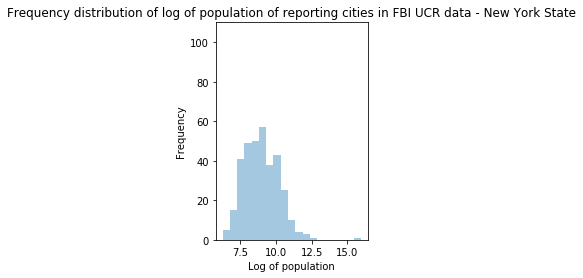

In [339]:
#Review the log of population distribution
plt.subplot(1, 2, 1)
plt.ylim(0,110)
sns.distplot(df.pop_log, kde=False)
plt.xlabel('Log of population')
plt.ylabel('Frequency')
plt.title('Frequency distribution of log of population of reporting cities in FBI UCR data - New York State')

In [340]:
# Create a minimal dataframe for the first iteration of the model
df_m1 = df.filter(['population', 'pop_sq','murder_ind','robbery_ind', 'property_crime'])

In [341]:
df_m1.describe()

,population,pop_sq,murder_ind,robbery_ind,property_crime
count,3.420000e+02,3.420000e+02,342.000000,342.000000,342.000000
mean,4.071809e+04,2.071258e+11,0.143275,0.611111,806.511696
std,4.539497e+05,3.811879e+12,0.350866,0.488212,7726.090635
min,5.260000e+02,2.766760e+05,0.000000,0.000000,1.000000
25%,3.077500e+03,9.471553e+06,0.000000,0.000000,42.000000
50%,7.465500e+03,5.573375e+07,0.000000,1.000000,114.000000
75%,1.927950e+04,3.717036e+08,0.000000,1.000000,342.500000
max,8.396126e+06,7.049493e+13,1.000000,1.000000,141971.000000


In [342]:
corr_matrix = (df_m1.corr())
display(corr_matrix)

,population,pop_sq,murder_ind,robbery_ind,property_crime
population,1.000000,0.998273,0.161939,0.063360,0.996267
pop_sq,0.998273,1.000000,0.132878,0.043400,0.991048
murder_ind,0.161939,0.132878,1.000000,0.309105,0.190226
robbery_ind,0.063360,0.043400,0.309105,1.000000,0.078133
property_crime,0.996267,0.991048,0.190226,0.078133,1.000000


#### None of the variables appear to be highly correlated with each other.

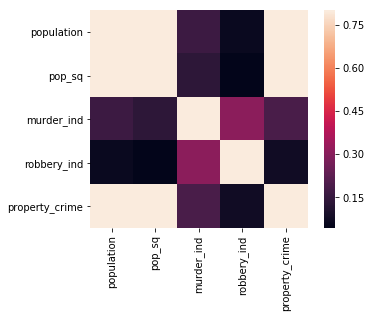

In [343]:
sns.heatmap(corr_matrix, vmax=.8, square=True)
plt.show()

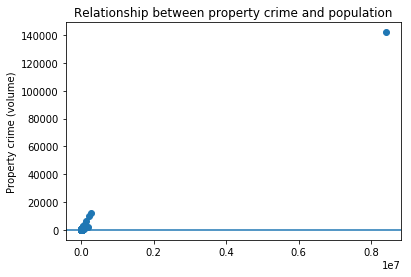

In [344]:
#Scatterplot property crime, population
plt.scatter(df['population'], df['property_crime'])
plt.ylabel('Property crime (volume)')
plt.axhline(y=0)
plt.title('Relationship between property crime and population')
plt.show()

### Running the model and verifying assumptions

Below I run the model with the formula as instructed in the exercise. 

The R-squared value seems too good to be true. Heteroscedasticity violates an assumption for a linear regression model and is discussed below.

The variable with the highest predictive value in the first iteration of the model is the murder categorical variable.

In [345]:
# Instantiate and fit the first iteration (m1) of the model.
m1 = linear_model.LinearRegression()
Y = df_m1['property_crime'].values.reshape(-1, 1)
X = df_m1[['population','pop_sq','murder_ind', 'robbery_ind']]
m1.fit(X, Y)

print('\nCoefficients: \n', m1.coef_)
print('\nIntercept: \n', m1.intercept_)
print('\nR-squared:')
print(m1.score(X, Y))


Coefficients: 
 [[ 3.46646245e-02 -2.11198069e-09  1.50103633e+01 -9.33937518e+01]]

Intercept: 
 [-112.59678124]

R-squared:
0.9961253851151026


#### Check linear relationship

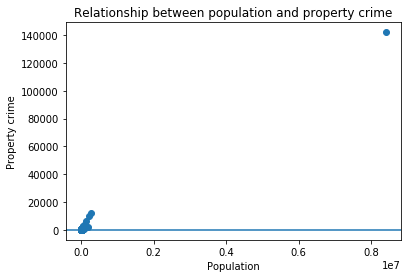

In [346]:
#Scatterplot population v property crime
plt.scatter(df_m1['population'], df_m1['property_crime'])
plt.xlabel('Population')
plt.ylabel('Property crime')
plt.axhline(y=0)
plt.title('Relationship between population and property crime')
plt.show()

#### Check multivariate normality by examining the distribution of errors

There are outliers in the error on both the low and high ends. This could be related to outliers in the underlying data; either in population, or property crime, or both.

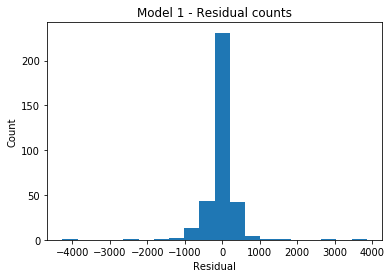

In [347]:
# Extract predicted values.
predicted = m1.predict(X).ravel()
actual = df_m1['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted
df_m1['residual'] = residual

plt.hist(df_m1['residual'], bins=20)
plt.title('Model 1 - Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [348]:
df_m1['residual'].describe()

count    3.420000e+02
mean    -1.243242e-13
std      4.809214e+02
min     -4.260176e+03
25%     -9.140389e+01
50%      5.542675e+01
75%      1.356521e+02
max      3.852600e+03
Name: residual, dtype: float64

#### Check assumption of homoscedascity

There is higher error for both high and low outcomes in model iteration 1.

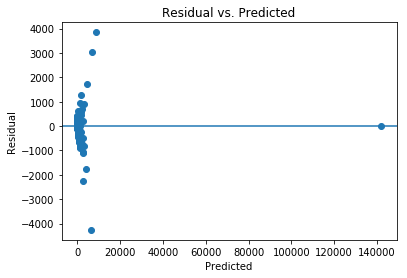

In [349]:
#Plot residual v predicted
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

#### Check correlations among features (multicolinearity)

As shown in an earlier figure, the features do not appear to be highly correlated with one another (except as expected, for population and population squared).

In [350]:
display(corr_matrix)

,population,pop_sq,murder_ind,robbery_ind,property_crime
population,1.000000,0.998273,0.161939,0.063360,0.996267
pop_sq,0.998273,1.000000,0.132878,0.043400,0.991048
murder_ind,0.161939,0.132878,1.000000,0.309105,0.190226
robbery_ind,0.063360,0.043400,0.309105,1.000000,0.078133
property_crime,0.996267,0.991048,0.190226,0.078133,1.000000


### Fixing assumptions

#### Heteroscedasticity can be corrected by transforming the dependent variable and/or adding features in poorly estimated areas. Heteroscedasticity can result in over-confidence in the model predictions. 

#### Here I test correcting for heteroscedasticity by transforming the dependent variable, property crime, by taking its square root.

In [351]:
df_m2 = df.filter(['population', 'pop_sq','pop_log', 'murder_ind','robbery_ind', 'property_crime', 'pty_crime_sqrt', 'pty_crime_log'])

In [352]:
m2 = linear_model.LinearRegression()
Y = df_m2['pty_crime_sqrt'].values.reshape(-1, 1)
X = df_m2[['population','pop_sq','murder_ind', 'robbery_ind']]
m2.fit(X, Y)

print('\nCoefficients: \n', m2.coef_)
print('\nIntercept: \n', m2.intercept_)
print('\nR-squared:')
print(m2.score(X, Y))


Coefficients: 
 [[ 3.79561635e-04 -4.00632569e-11  3.88414493e+00  5.77107738e+00]]

Intercept: 
 [4.53405993]

R-squared:
0.9503900294517691


I now have a positive intercept and the violent crime indicators both have predictive value. The R-squared seems more reasonable (that is, it doesn't seem as if accuracy is as seriously over-estimated as in iteration 1).

Iteration 2.1     I would like to know if including population squared predictor improves the model (it does).

In [353]:
m2_1 = linear_model.LinearRegression()
Y = df_m2['pty_crime_sqrt'].values.reshape(-1, 1)
X = df_m2[['population', 'murder_ind', 'robbery_ind']]
m2_1.fit(X, Y)

print('\nCoefficients: \n', m2_1.coef_)
print('\nIntercept: \n', m2_1.intercept_)
print('\nR-squared:')
print(m2_1.score(X, Y))


Coefficients: 
 [[4.20597538e-05 1.51214358e+01 9.58222569e+00]]

Intercept: 
 [6.03930449]

R-squared:
0.8475445560095297


Iteration 2.2     Here the model is run with the dependent variable transformed to its log. Performance does not improve, unless we consider the R-squared of 0.9504 in the previous iteration an over-estimate of accuracy.

In [354]:
m2_2 = linear_model.LinearRegression()
Y = df_m2['pty_crime_log'].values.reshape(-1, 1)
X = df_m2[['population', 'pop_sq', 'murder_ind', 'robbery_ind']]
m2_2.fit(X, Y)

print('\nCoefficients: \n', m2_2.coef_)
print('\nIntercept: \n', m2_2.intercept_)
print('\nR-squared:')
print(m2_2.score(X, Y))


Coefficients: 
 [[ 2.53312085e-05 -2.92565093e-12  4.94593986e-01  1.63131662e+00]]

Intercept: 
 [3.29309527]

R-squared:
0.6906820853080369


Iteration 2.3    Run the model with the log of property crime (dependent variable) and the log of population. The best scoring model so far has an R-squared of ~0.9504. This may still over-state the accuracy. I am going to proceed with more iterations using the log of the property crime value and the log of population as variables.

In [355]:
df_m2_3 = df_m2
m2_3 = linear_model.LinearRegression()
Y = df_m2_3['pty_crime_log'].values.reshape(-1, 1)
X = df_m2_3[['pop_log', 'murder_ind', 'robbery_ind']]
m2_3.fit(X, Y)

print('\nCoefficients: \n', m2_3.coef_)
print('\nIntercept: \n', m2_3.intercept_)
print('\nR-squared:')
print(m2_3.score(X, Y))


Coefficients: 
 [[0.91059485 0.29998873 0.87008399]]

Intercept: 
 [-3.97381438]

R-squared:
0.8031438881167701


Re-test for heteroscedascity.

In [356]:
# Extract predicted values.
predicted_m2_3 = m2_3.predict(X).ravel()
actual = df_m2_3['pty_crime_log']

# Calculate the error, also called the residual.
residual_m2_3 = actual - predicted

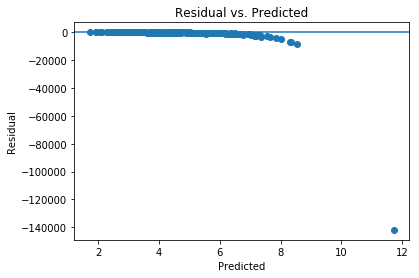

In [357]:
#Plot residual v predicted
plt.scatter(predicted_m2_3, residual_m2_3)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

#### Multivariate non-normality results in mis-estimation. It can be corrected by dealing with outliers. I will iterate the model two times by first excluding the high outliers, then the low outliers based on population. I am going to keep the transformation of property crime to the square root.

Dropping the high population outliers (iteration 3, below) is not an improvement.

In [358]:
df_m3 = df.filter(['population', 'pop_log','murder_ind','robbery_ind', 'pty_crime_log', 'property_crime', 'outlier_flag'])

In [359]:
df_m3.drop(df_m3[df_m3['outlier_flag'] == 1].index, inplace=True)

In [360]:

m3 = linear_model.LinearRegression()
Y = df_m3['pty_crime_log'].values.reshape(-1, 1)
X = df_m3[['pop_log','murder_ind', 'robbery_ind']]
m3.fit(X, Y)

print('\nCoefficients: \n', m3.coef_)
print('\nIntercept: \n', m3.intercept_)
print('\nR-squared:')
print(m3.score(X, Y))


Coefficients: 
 [[0.89301191 0.27789875 0.88973037]]

Intercept: 
 [-3.83099718]

R-squared:
0.7829625070761145


Dropping both the high and low population outliers (below) does not improve the model.

In [361]:
df_m4 = df.filter(['population', 'pop_log','murder_ind','robbery_ind', 'property_crime', 'pty_crime_log', 'outlier_flag', 'low_outlier'])
df_m4.drop(df_m4[df_m4['outlier_flag'] == 1].index, inplace=True)
df_m4.drop(df_m4[df_m4['low_outlier'] == 1].index, inplace=True)

In [362]:
m4 = linear_model.LinearRegression()
Y = df_m4['pty_crime_log'].values.reshape(-1, 1)
X = df_m4[['pop_log','murder_ind', 'robbery_ind']]
m4.fit(X, Y)

print('\nCoefficients: \n', m4.coef_)
print('\nIntercept: \n', m4.intercept_)
print('\nR-squared:')
print(m4.score(X, Y))


Coefficients: 
 [[0.96711357 0.26480966 0.98224443]]

Intercept: 
 [-4.67171092]

R-squared:
0.7039488730657126


Adding indicators for the first and fourth quartiles in population improves the model slightly.

In [363]:
df_m6 = df.filter(['population', 'pop_log','murder_ind','robbery_ind', 'pty_crime_log', 'property_crime', 'qrtl_1', 'qrtl_4'])

In [364]:
m6 = linear_model.LinearRegression()
Y = df_m6['pty_crime_log'].values.reshape(-1, 1)
X = df_m6[['pop_log','murder_ind', 'robbery_ind', 'qrtl_4']]
m6.fit(X, Y)

print('\nCoefficients: \n', m6.coef_)
print('\nIntercept: \n', m6.intercept_)
print('\nR-squared:')
print(m6.score(X, Y))


Coefficients: 
 [[0.89506238 0.28601834 0.88751512 0.41483977]]

Intercept: 
 [-3.84769376]

R-squared:
0.8037651400654878


Dropping the murder predictor does not improve the performance of the model.

In [365]:
m6_1 = linear_model.LinearRegression()
Y = df_m6['pty_crime_log'].values.reshape(-1, 1)
X = df_m6[['pop_log','robbery_ind', 'qrtl_1', 'qrtl_4']]
m6_1.fit(X, Y)

print('\nCoefficients: \n', m6_1.coef_)
print('\nIntercept: \n', m6_1.intercept_)
print('\nR-squared:')
print(m6_1.score(X, Y))


Coefficients: 
 [[0.94954316 0.9060492  0.07917618 0.44141924]]

Intercept: 
 [-4.32683855]

R-squared:
0.8011779917091149


Per capita measures are often used when analyzing data of this type. But the way I have it constructed, they do not result in a better model.

In [366]:
df_m7 = df.filter(['population', 'pty_crime_pc', 'murder_pc', 'murder_ind', 'robbery_pc', 'robbery_ind', 'violent_pc', 'qrtl_1', 'qrtl_4'])

In [367]:
m7 = linear_model.LinearRegression()
Y = df_m7['pty_crime_pc'].values.reshape(-1, 1)
X = df_m7[['robbery_pc', 'murder_pc', 'qrtl_1', 'qrtl_4']]
m7.fit(X, Y)

print('\nCoefficients: \n', m7.coef_)
print('\nIntercept: \n', m7.intercept_)
print('\nR-squared:')
print(m7.score(X, Y))


Coefficients: 
 [[ 1.06842427e+01 -4.08154257e+01 -1.05898577e-03 -1.74557056e-02]]

Intercept: 
 [0.01663942]

R-squared:
0.19267624712104348


These two plots show that using per capita measures rather than volume takes away the predictive power of the murder and robbery statistics.

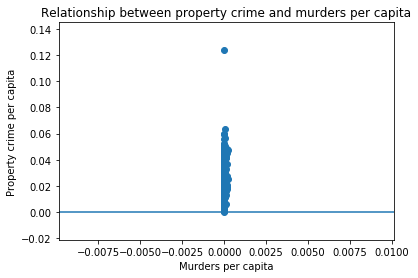

In [368]:
#Scatterplot property crime, murder crime per capita
plt.scatter(df['murder_pc'], df['pty_crime_pc'])
plt.xlabel('Murders per capita')
plt.ylabel('Property crime per capita')
plt.axhline(y=0)
plt.title('Relationship between property crime and murders per capita')
plt.show()

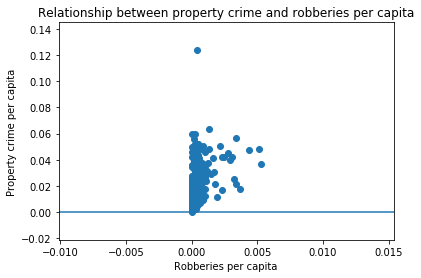

In [369]:
#Scatterplot property crime, murder crime per capita
plt.scatter(df['robbery_pc'], df['pty_crime_pc'])
plt.xlabel('Robberies per capita')
plt.ylabel('Property crime per capita')
plt.axhline(y=0)
plt.title('Relationship between property crime and robberies per capita')
plt.show()

### Discussion and summary: Feature engineering and selection

The model based on the original formula (property crime volume = population + population squared + robbery volume + murder volume) resulted in an R-squared value that was unreasonably high (~0.9961); accuracy was over-estimated.

The second iteration of the model used the square root of the dependent variable to address heteroscedacity. This model resulted in an R-squared value of ~0.9504. This model may also overstate accuracy.

The third major iteration of the model used the log of the dependent variable (property crime volume) and the log of population. The R-squared value of this model is ~0.8031. A minor improvement could be made by including a predictor indicating whether population is in the fourth quartile (R-squared ~0.8037).

I constructed a model using per capita values for property crime volume, murder volume and robbery volume. Plots show that the predictive power of the murder and robbery volumes were neutralized when transformed to per capita values.